In [1]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from scipy.optimize import curve_fit
from math import log10, floor
import time 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
import glob
from scipy import interpolate, signal
from scipy.stats import norm

import tkp.db
import tkp.config

import matplotlib.gridspec as gridspec

import matplotlib
%matplotlib notebook

In [2]:
def run_query(transients_query, dbname, dataset_id, 
              engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
#     print "Found", len(transients), "new sources"
    return transients

def get_runcats(ra, dec, radius, dbname, dataset, 
                engine, host, port, user, password ):
    '''Search celestial coordinate for running catalogues from TraP database '''
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

    transients_query = """SELECT id, wm_ra, wm_decl, datapoints FROM runningcatalog WHERE 
        runningcatalog.wm_ra >= {} AND 
        runningcatalog.wm_ra <= {} AND 
        runningcatalog.wm_decl >= {} AND 
        runningcatalog.wm_decl <= {};
        """.format(ra-radius, ra+radius,
                   dec-radius, dec+radius)

    runcats = pd.DataFrame(run_query(transients_query, dbname, dataset, 
                                 engine, host, port, user, password))
    db._configured = False
    del db, session
    
    return runcats

def get_lightcurve(_id, dbname, dataset,
                   engine, host, port, user, password):
    '''Grab one runcat from a trap database.'''

    try:
        db._configured = False
        del db, session
    except UnboundLocalError:
        print ""
        
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

    transients_query = """SELECT ex.f_int, ex.f_int_err,ex.f_peak, 
        ex.det_sigma, extract_type, 
        ex.ra,
        ex.ra_err,
        ex.decl,
        ex.decl_err,
        im.band, 
        im.taustart_ts,
        im.freq_eff
        FROM extractedsource ex, image im 
        WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat = {}) 
        AND ex.image = im.id;
        """.format(_id)

    try: 
        TR_data = pd.DataFrame(run_query(transients_query, dbname, dataset, 
                                     engine, host, port, user, password))
    except OperationalError:
        print "doesnt work"
        db._configured = False
        del db, session
        
    db._configured = False
    del db, session
    
    return TR_data

In [5]:
cat_8C = pd.read_csv("~/8c_cat.txt", delimiter="|", comment="#")
# cat_8C = cat_8C[cat_8C.Sint > 1.]

In [3]:
import logging
import pylab
import datetime
import matplotlib.dates as mdates

engine = 'postgresql'
host = 'localhost'
port = 5432
user = 'mkuiack1'
password = 'mkuiack1'
query_loglevel = logging.WARNING



427

In [9]:

_id =10


dbname = "meteor-16SB-311"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

print "database name: ",  dbname

database_values = (dbname, dataset, engine, host, port, user, password)
TR_data = get_lightcurve(_id, *database_values)


database name:  meteor-16SB-311



In [10]:
TR_data

Empty DataFrame
Columns: []
Index: []

In [39]:
[3,4,5,24,186,21,18,6,13,137,27,16,26,376]

In [85]:
run_cats

Empty DataFrame
Columns: []
Index: []

In [6]:
dbname = "meteor-16SB-311"
dataset = 1
database_values = (dbname, dataset, engine, host, port, user, password)
count = 0

all_8C = pd.DataFrame([])
for cat_source in cat_8C.index:
    run_cats = get_runcats(cat_8C.loc[cat_source]._RAJ2000, 
                           cat_8C.loc[cat_source]._DEJ2000, 0.2, *database_values)
    if len(run_cats) > 0:    
        run_cats = run_cats[run_cats.datapoints > 100.]
    if len(run_cats) > 0:
#         print run_cats.sort_values("datapoints", ascending=False)
        run_cats.sort_values("datapoints", ascending=False, inplace=True)
        all_8C = pd.concat([all_8C, pd.DataFrame(run_cats.iloc[0]).T])
        count +=1 
print count 

KeyboardInterrupt: 

In [ ]:
all_8C

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.errorbar(TR_data.taustart_ts, 
             TR_data.f_int, yerr=TR_data.f_int_err, fmt=",", color="black", ecolor="C0")

myFmt = mdates.DateFormatter('%H:%M:%S')
plt.xticks(rotation=10)
ax.xaxis.set_major_formatter(myFmt)

In [97]:
all_8C.id.values.astype("int")

array([27, 26, 50, 80, 23, 16, 58, 29, 44, 32])

<IPython.core.display.Javascript object>


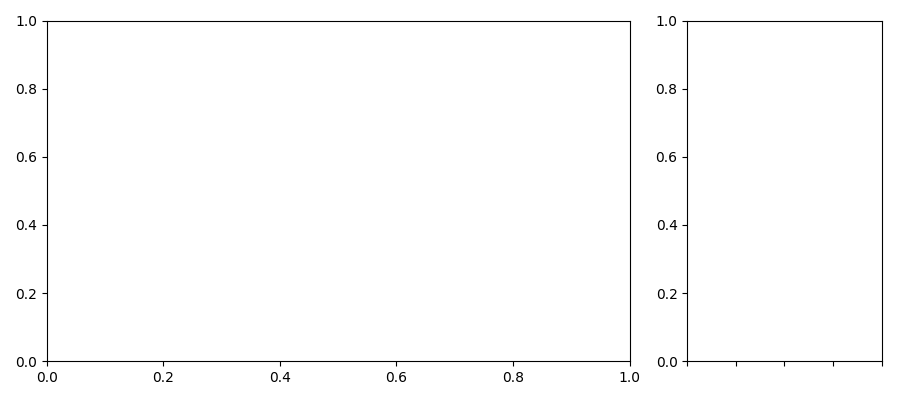

In [35]:
import matplotlib.gridspec as gridspec

fig2 = plt.figure(figsize=(9,4),constrained_layout=False)
spec2 = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[3, 1], figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0])
f3_ax1 = fig2.add_subplot(spec2[1])
f3_ax1.set_xticklabels([])
fig2.tight_layout()

/home/mkuiack1/env/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


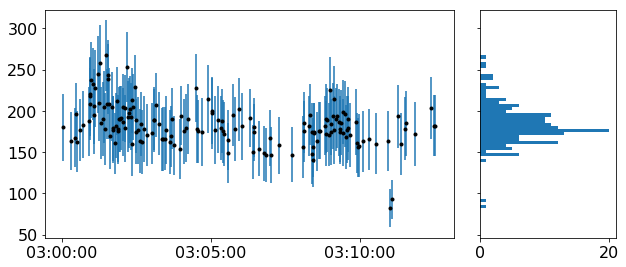

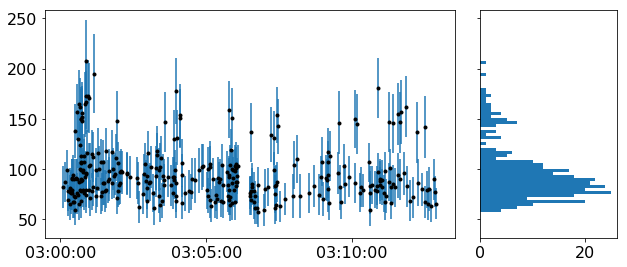

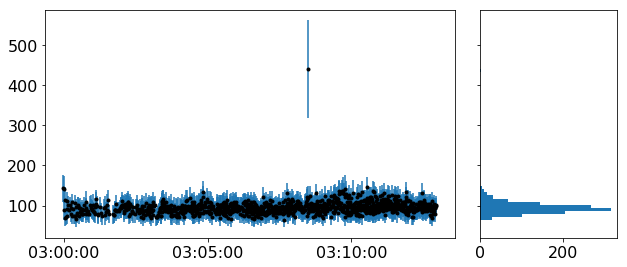

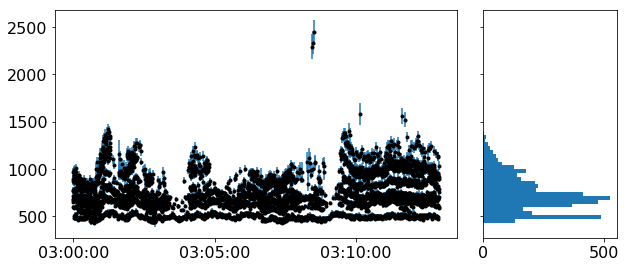

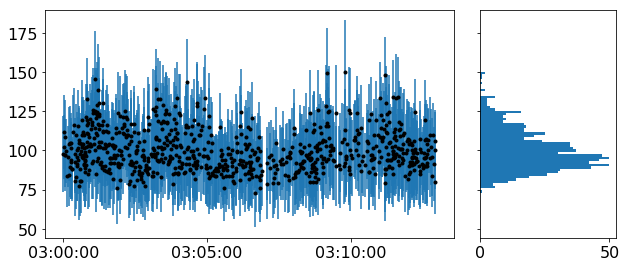

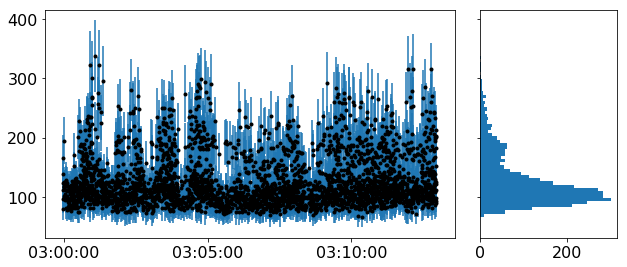

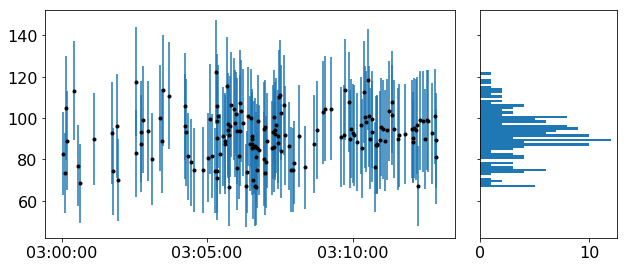

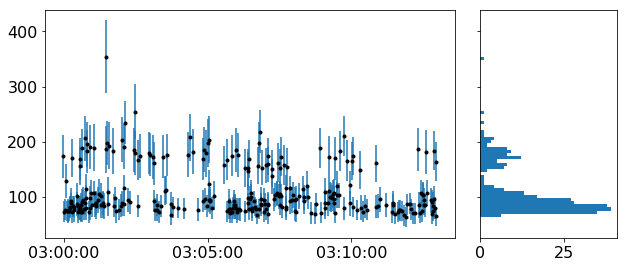

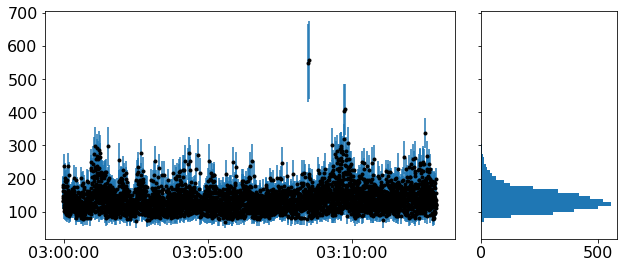

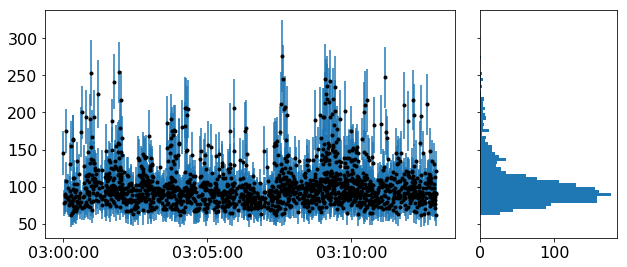

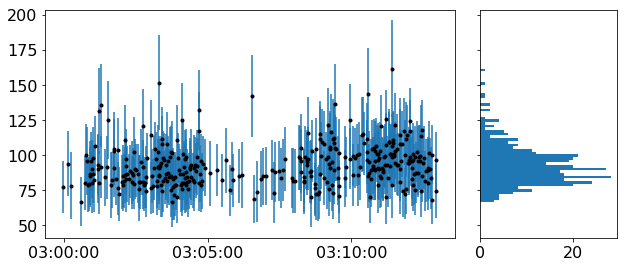

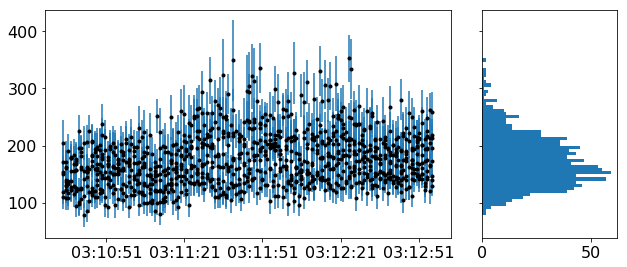

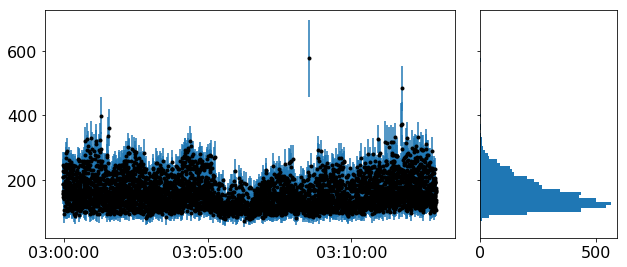

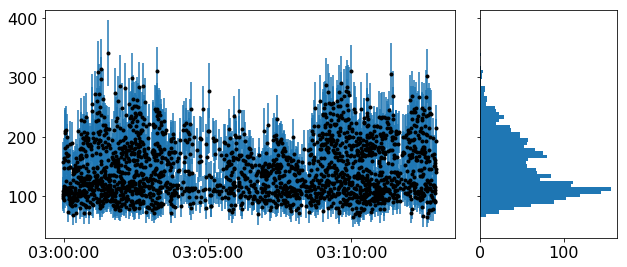

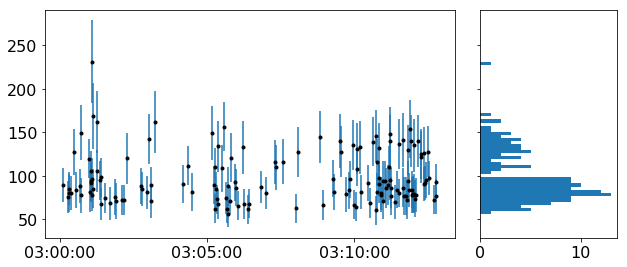

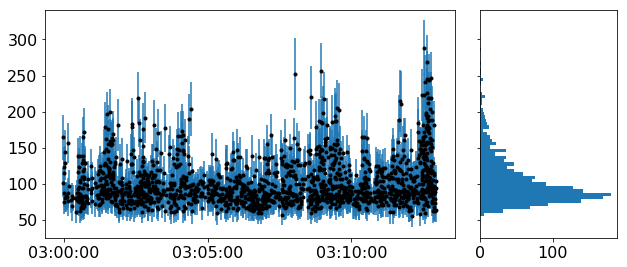

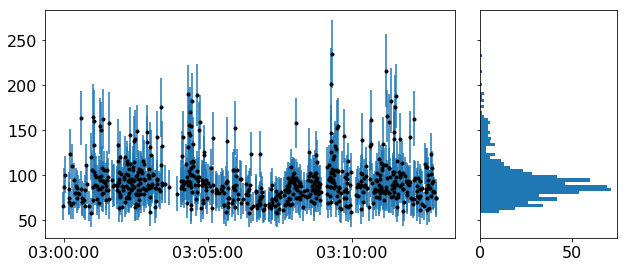

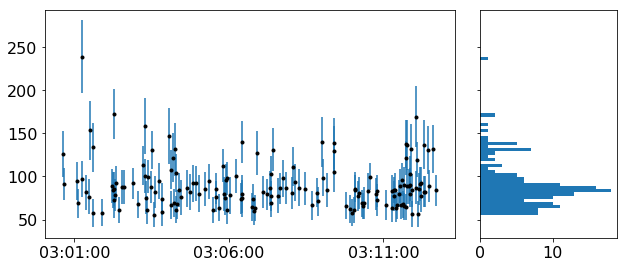

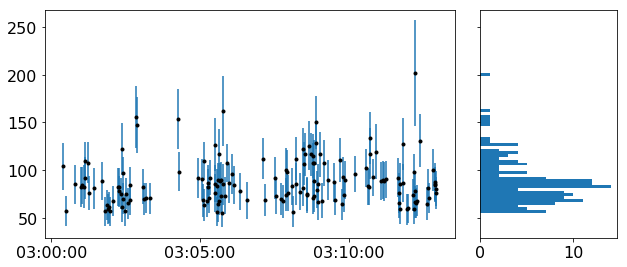

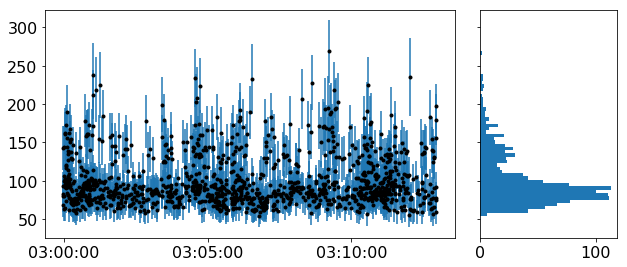

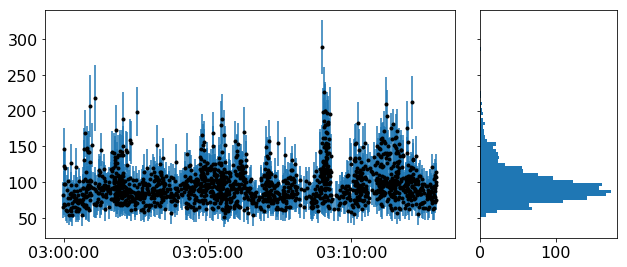

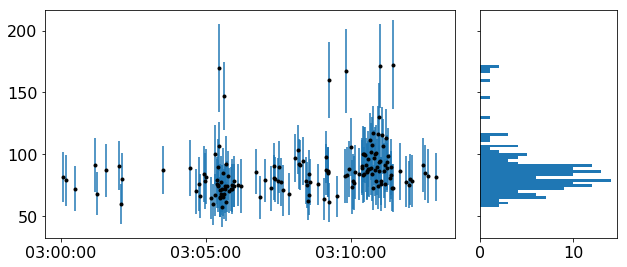

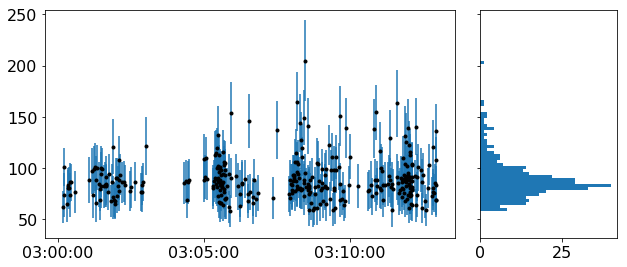

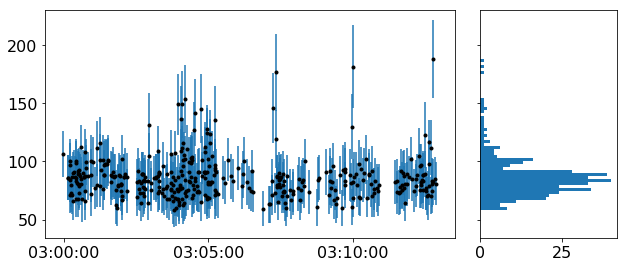

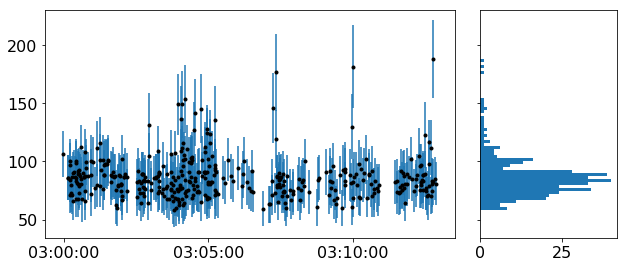

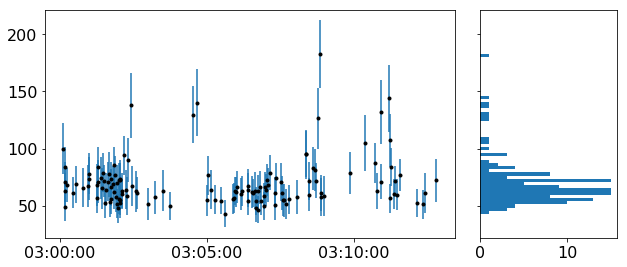

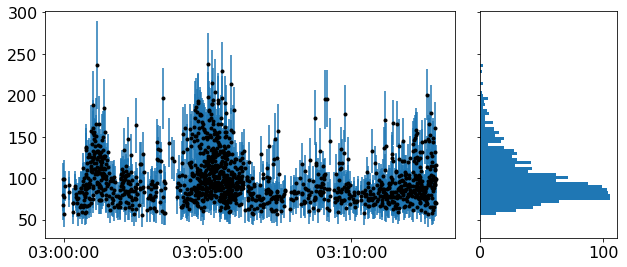

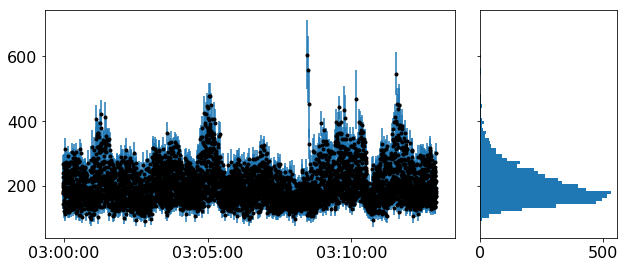

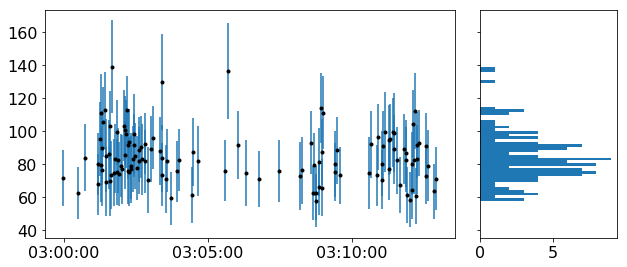

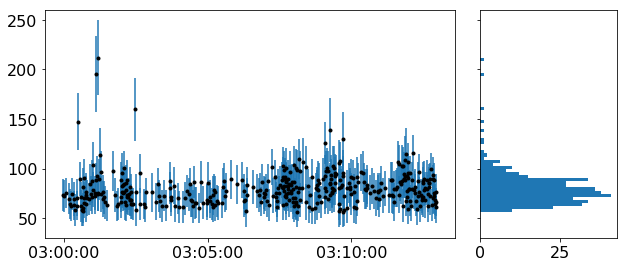

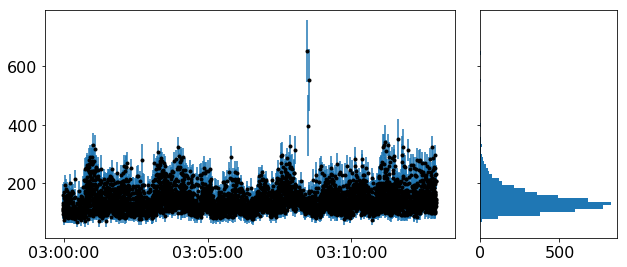

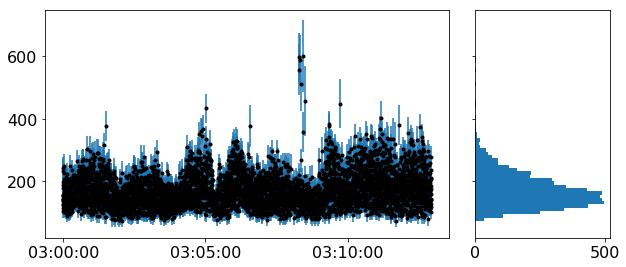

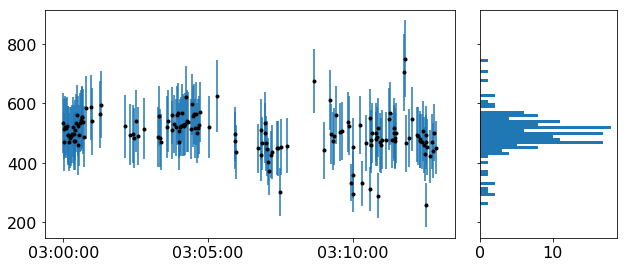

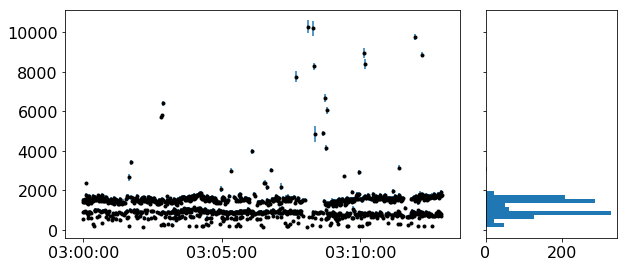

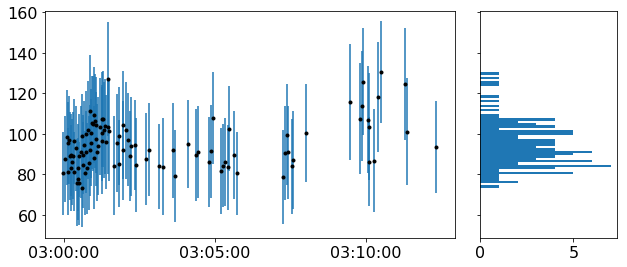

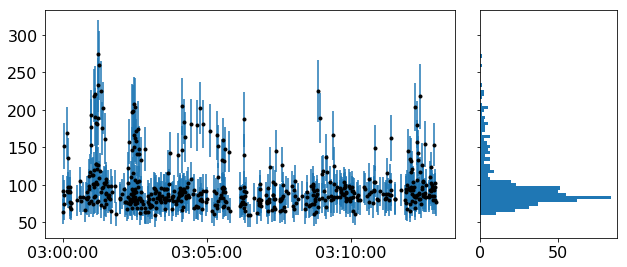

In [65]:
widths = [4, 1]

fluxes = []
flux_errs = []

for _id in all_8C.id.values.astype("int"):

    TR_data = get_lightcurve(_id, *database_values)
    fig2 = plt.figure(figsize=(9,4),constrained_layout=False)
    spec2 = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[3, 1], figure=fig2)




    f2_ax1 = fig2.add_subplot(spec2[0])
    f2_ax1.errorbar(TR_data.taustart_ts, 
                 TR_data.f_int, yerr=TR_data.f_int_err,  fmt=".", color="black", ecolor="C0")
  
    myFmt = mdates.DateFormatter('%H:%M:%S')
#     f2_ax1.set_xticklabels(rotation=10)
    f2_ax1.xaxis.set_major_formatter(myFmt)
    
    f2_ax2 = fig2.add_subplot(spec2[1])
    f2_ax2.set_yticklabels([])
    f2_ax2.hist(TR_data.f_int, bins=50, orientation="horizontal")
    f2_ax2.set_ylim(f2_ax1.axes.get_ylim())
    fig2.tight_layout()
   
    fluxes.append(np.median(TR_data.f_int))
    flux_errs.append(np.std(TR_data.f_int))
    
all_8C["fluxes"] = fluxes
all_8C["flux_errs"] = flux_errs

In [10]:
cat_8C = pd.read_csv("~/8c_cat.txt", delimiter="|", comment="#")

cat_pos = SkyCoord(ra=(cat_8C._RAJ2000*u.degree).values,
                      dec=(cat_8C._DEJ2000*u.degree).values)

In [ ]:
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np



In [55]:
%%timeit
sources_df = pd.DataFrame({'RA':(cat_8C._RAJ2000*u.degree).values,
                          'Dec':(cat_8C._DEJ2000*u.degree).values})

sources_df['RA'] = np.radians(sources_df['RA'])
sources_df['Dec'] = np.radians(sources_df['Dec'])

dist = DistanceMetric.get_metric('haversine')

pairwise_source_dists = np.rad2deg(dist.pairwise(sources_df[['RA','Dec']].to_numpy()))

# distance of nearest neighbour 
threshold = 1.0 

reduced_cat = cat_8C[np.sort(pairwise_source_dists, axis=1)[:,1] > threshold]

1 loop, best of 3: 5.82 s per loop


In [56]:
len(cat_8C)

5859

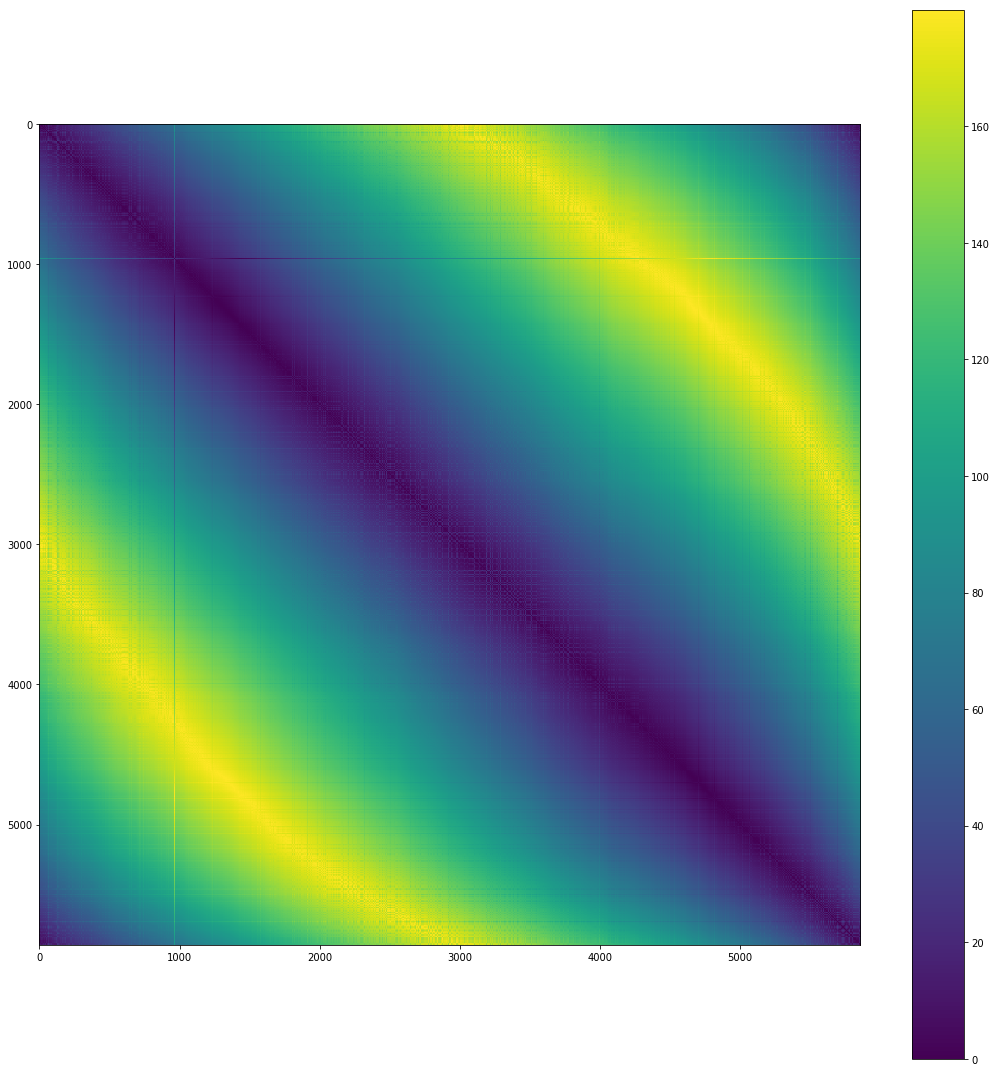

In [43]:
plt.figure(figsize=(15,15))
plt.imshow(pairwise_source_dists)
plt.colorbar()
plt.tight_layout()

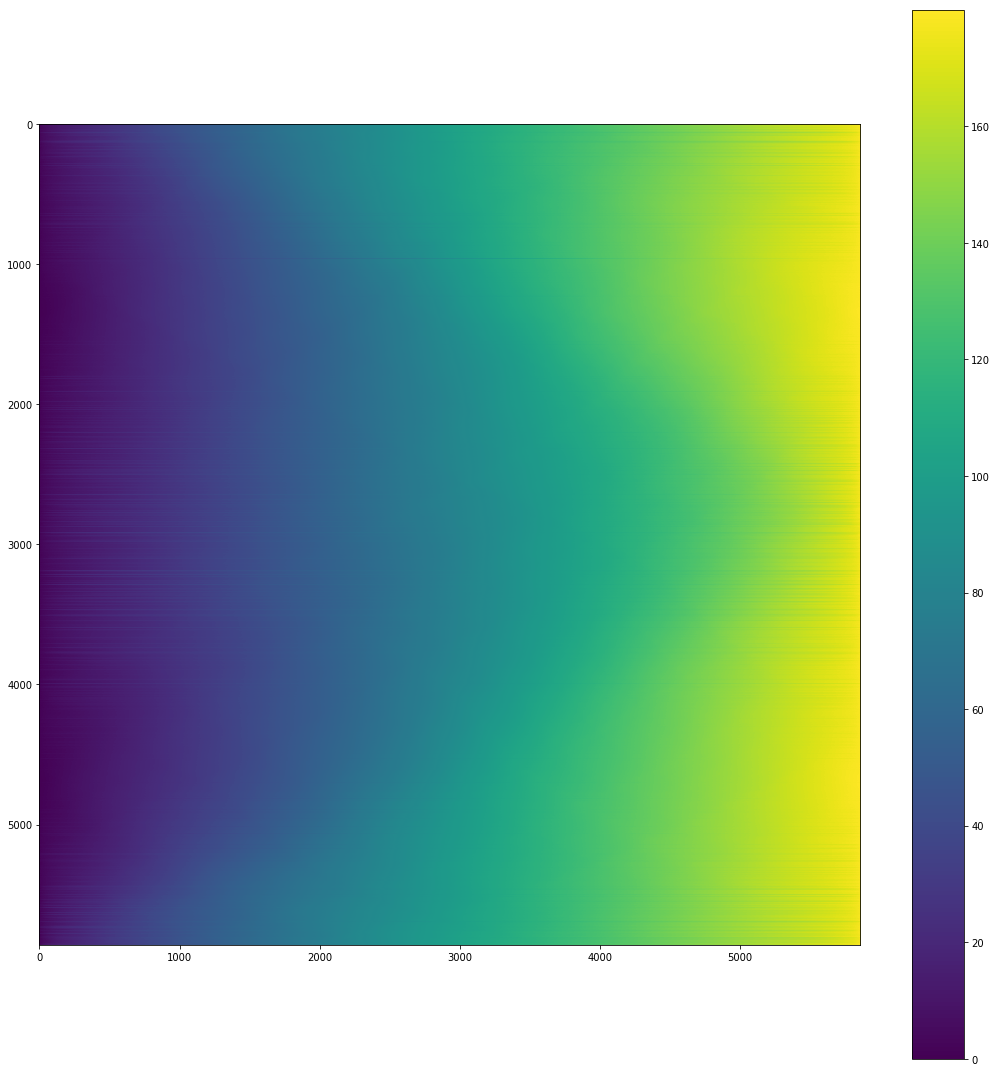

In [46]:
plt.figure(figsize=(15,15))
plt.imshow(np.sort(pairwise_source_dists, axis=1))
plt.colorbar()
plt.tight_layout()

((5859, 5859), 5859)

In [35]:
np.max(np.rad2deg(source_dists))

179.9907695816433

0.03704923201818961 0.07012721734667124
53.81726537440018 9.64230499338379
26.991112784984104
145.2


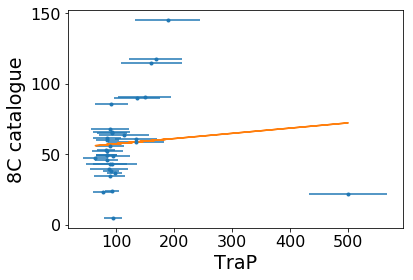

In [80]:
index = (cat_8C.Sint > 1) & (cat_8C.Sint < 300.)
cat_8C = cat_8C.loc[index]

pyse_coord = SkyCoord(ra=(all_8C.wm_ra*u.degree).values,
                      dec=(all_8C.wm_decl*u.degree).values)

cat_8C_coord = SkyCoord(ra=(cat_8C._RAJ2000*u.degree).values,
                       dec=(cat_8C._DEJ2000*u.degree).values)

idx, d2d, d3d = pyse_coord.match_to_catalog_sky(cat_8C_coord)

radius = .1

# pyse[d2d.deg < radius]
plt.figure()
plt.errorbar(all_8C[d2d.deg < radius]['fluxes'], 
         cat_8C.iloc[idx[d2d.deg < radius]].Sint,
             xerr=all_8C[d2d.deg < radius]['flux_errs'],fmt=".")

plt.xlabel("TraP")
plt.ylabel("8C catalogue")


fit, cov = np.polyfit(all_8C[d2d.deg < radius]['fluxes'],
           cat_8C.iloc[idx[d2d.deg < radius]].Sint, 1, cov=True)

print fit[0], np.sqrt(cov[0,0])
print fit[1], np.sqrt(cov[1,1])

plt.plot(all_8C[d2d.deg < radius]['fluxes'], 
         fit[0]*all_8C[d2d.deg < radius]['fluxes']+fit[1])

print 1./fit[0]
print np.max(cat_8C.iloc[idx[d2d.deg < radius]].Sint)

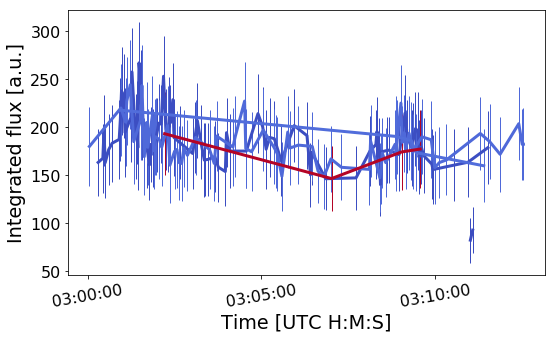

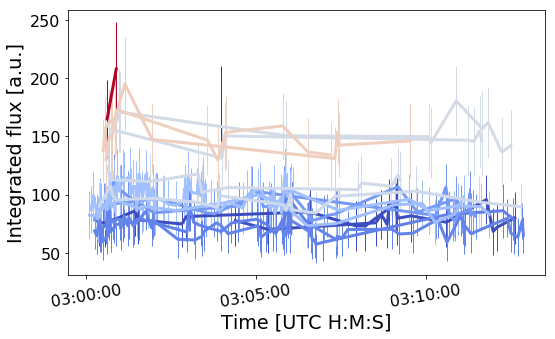

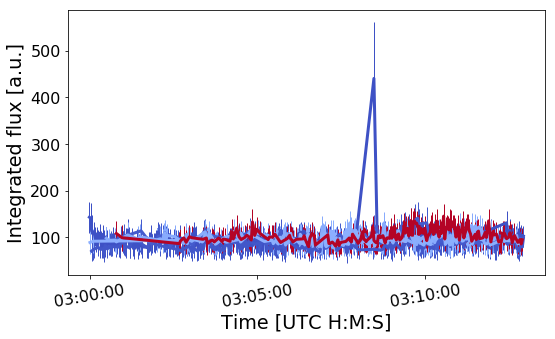

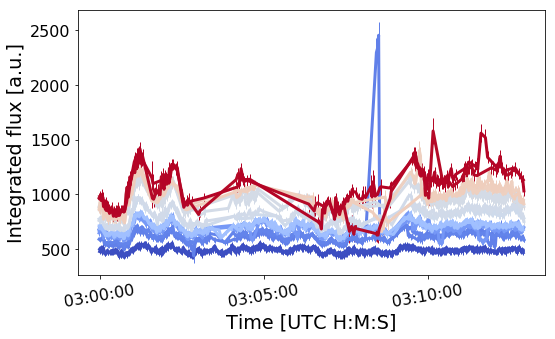

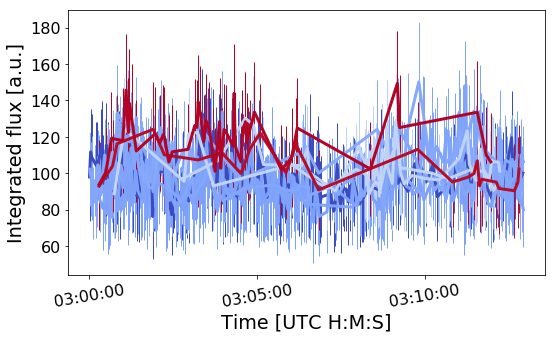

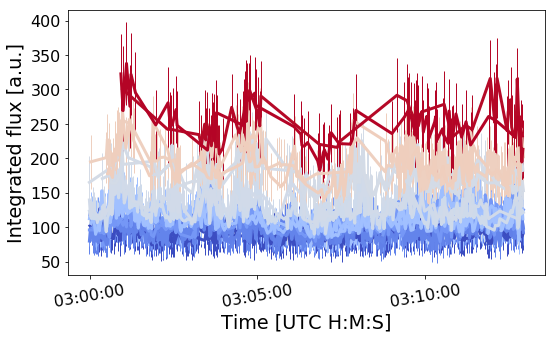

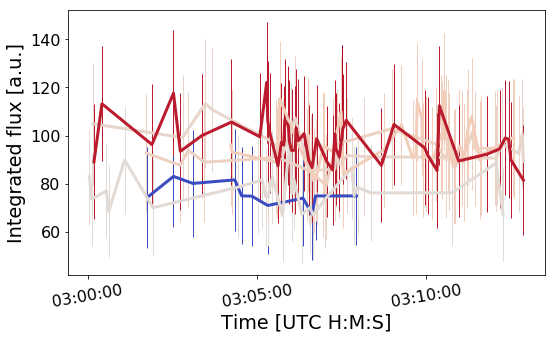

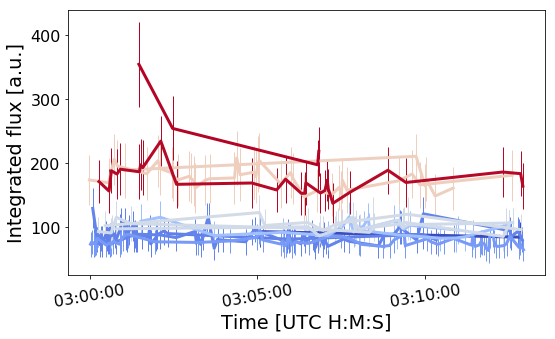

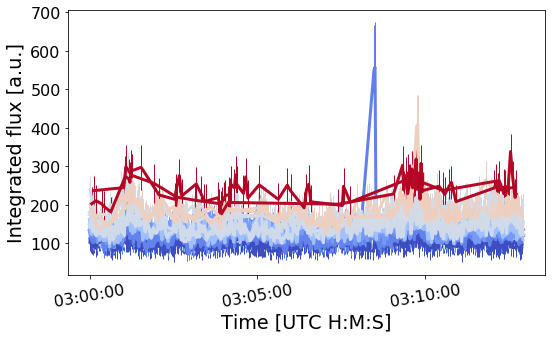

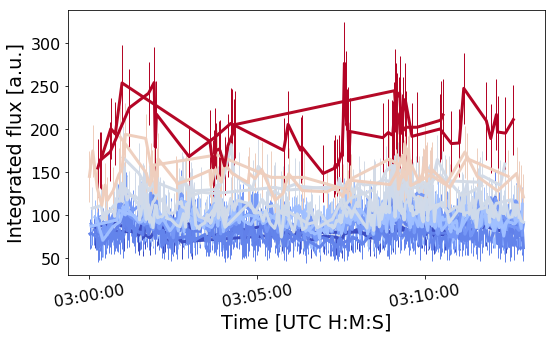

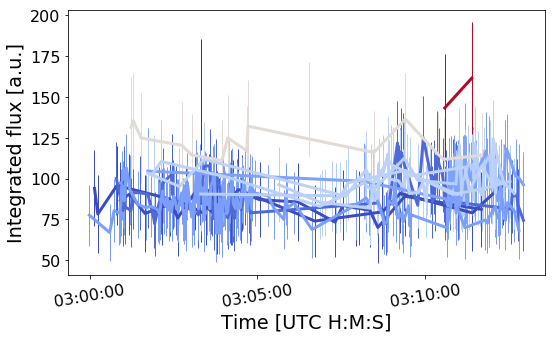

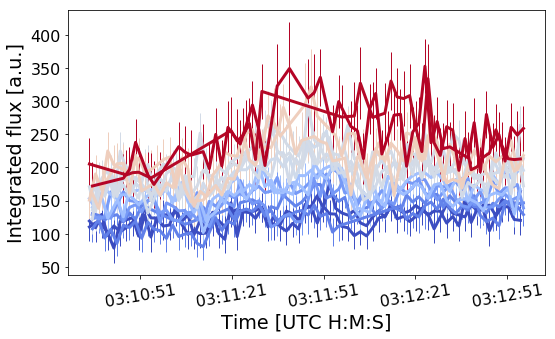

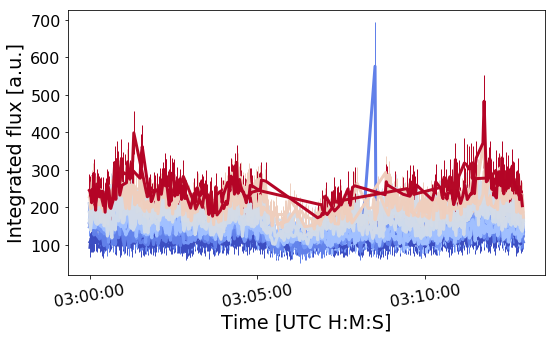

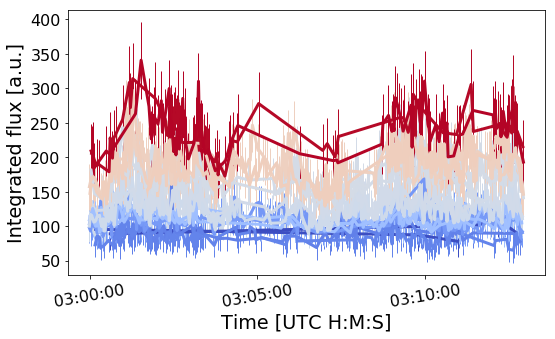

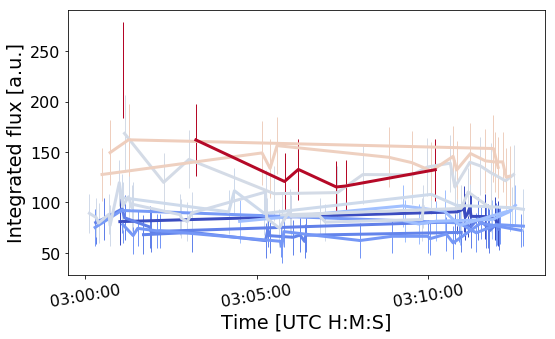

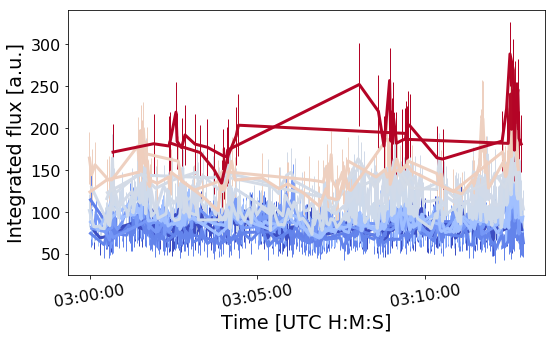

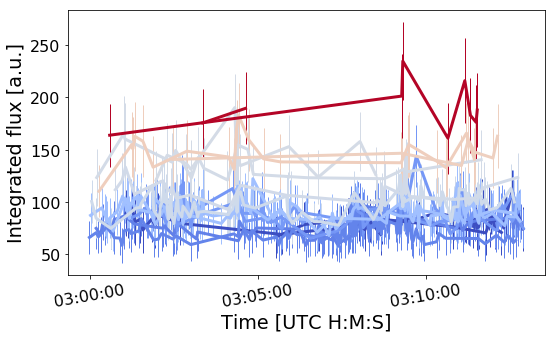

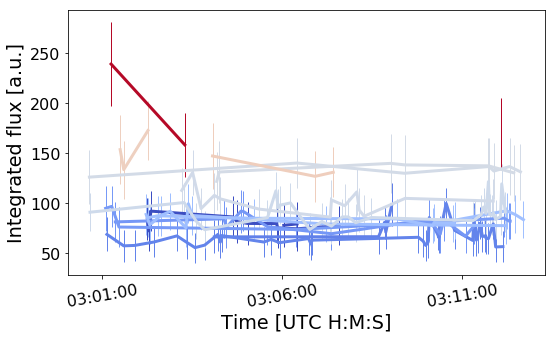

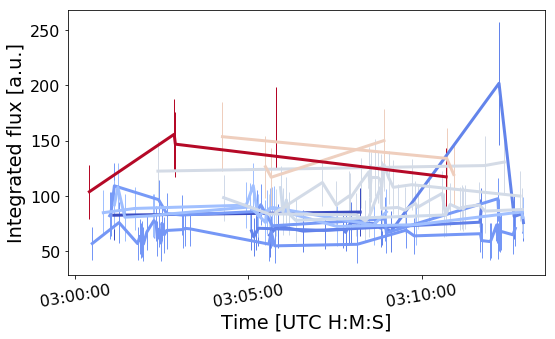

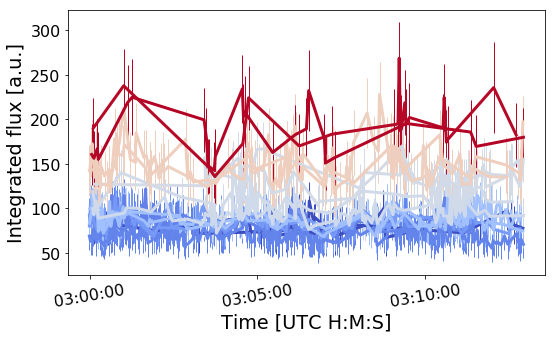

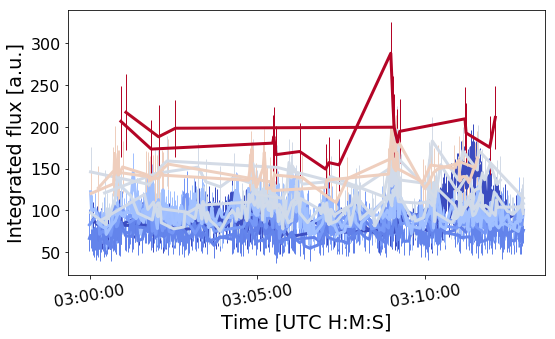

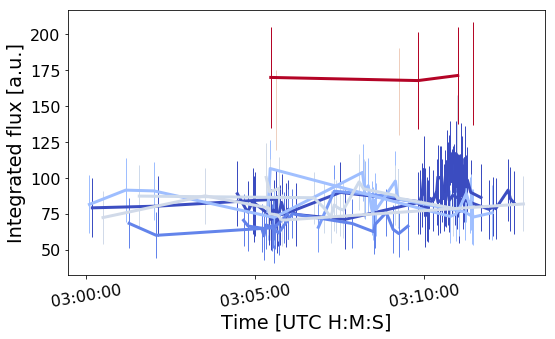

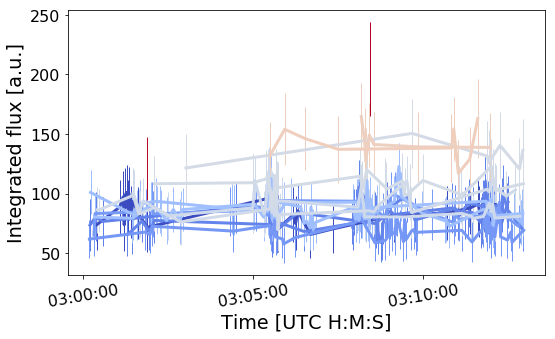

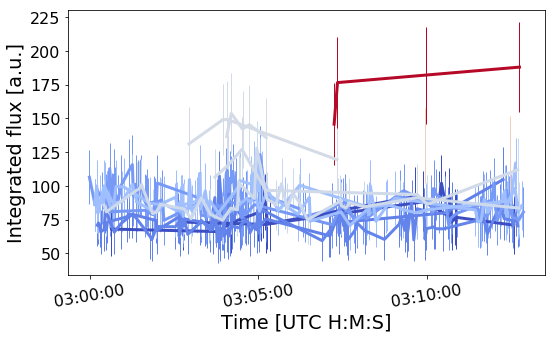

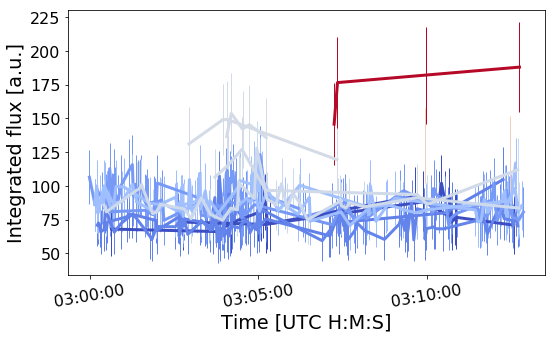

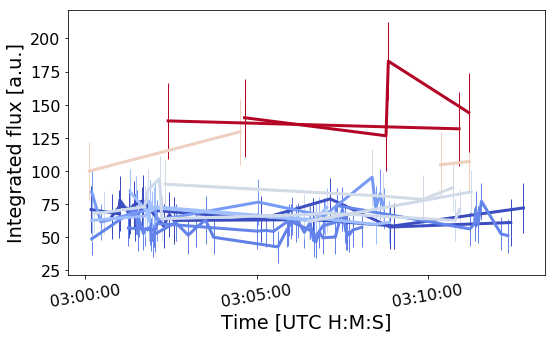

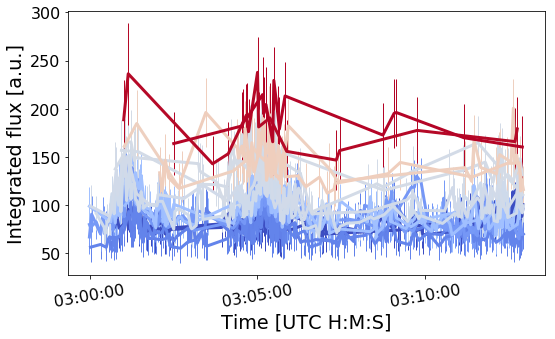

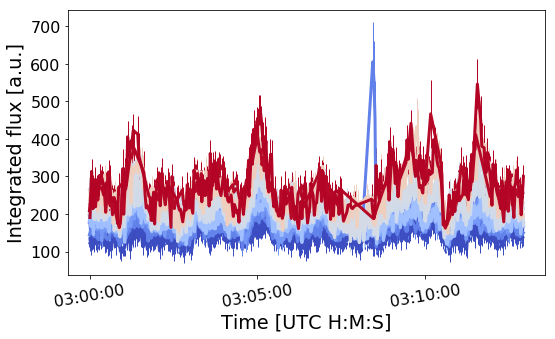

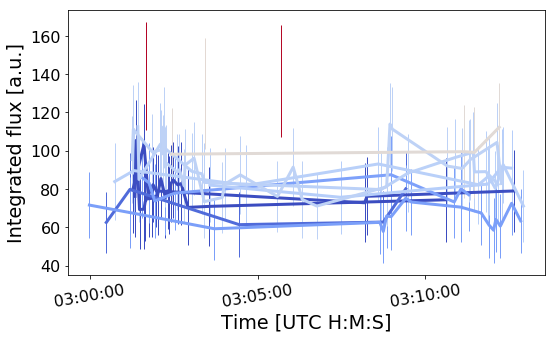

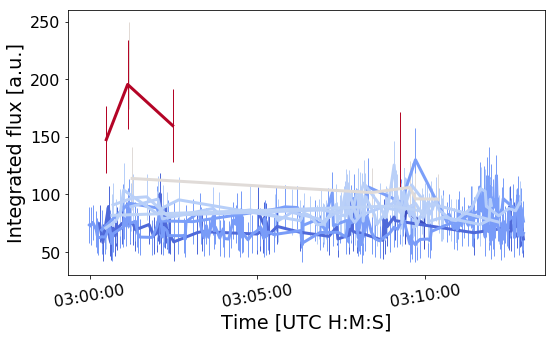

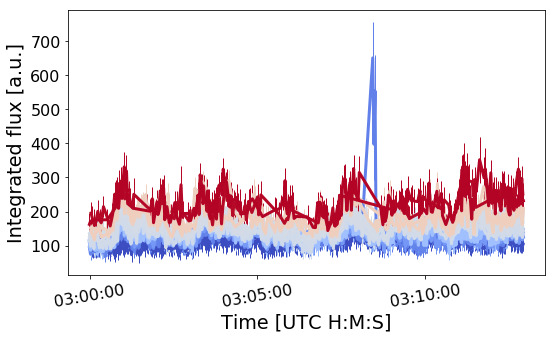

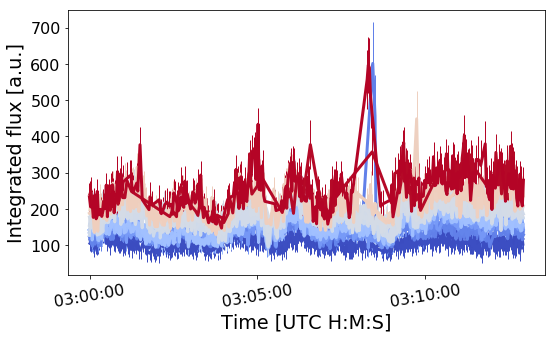

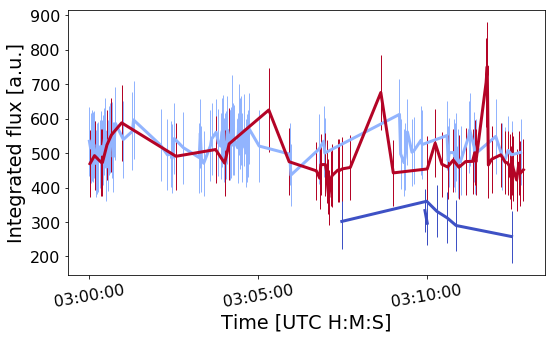

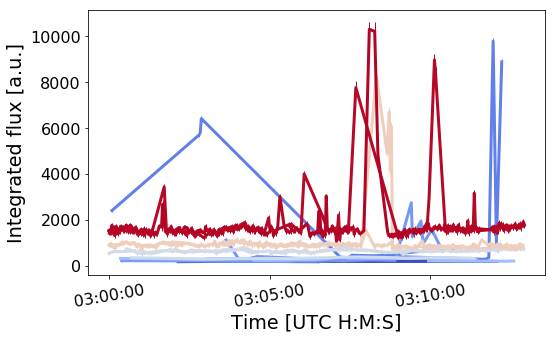

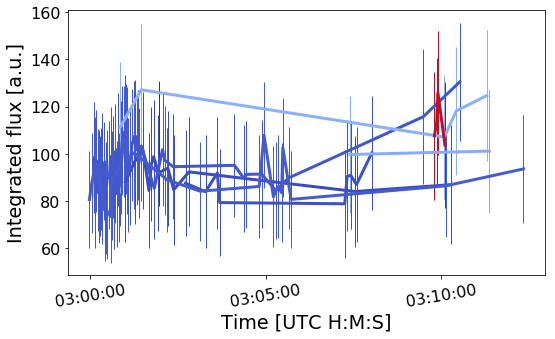

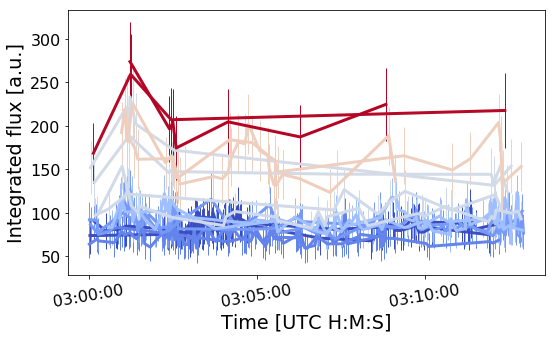

In [83]:
for _id in all_8C.id.values.astype("int"):

    TR_data = get_lightcurve(_id, *database_values)
    
    all_freq = np.unique(TR_data.freq_eff)
    scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
    colors = plt.cm.coolwarm(scaled_all_freq)
    n_c = 0 
    plt.figure(1, figsize = (8,5))
    
    for freq in all_freq[::-1]:

        ax = plt.subplot(111)

        burst = TR_data[(TR_data.freq_eff == freq)]# &
        burst.set_index(burst.taustart_ts, inplace=True)
        burst = burst.sort_index()


        xnew = [x.timestamp() for x in burst.taustart_ts]
        xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

        ax.errorbar(xaxis, burst.f_int, yerr=burst.f_int_err, linewidth=3,elinewidth=1,
                c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))


        myFmt = mdates.DateFormatter('%H:%M:%S')
        plt.xticks(rotation=10)
        ax.xaxis.set_major_formatter(myFmt)

        plt.ylabel("Integrated flux [a.u.]")
        plt.xlabel("Time [UTC H:M:S]")
        # burst_starts = (TR_data.loc[TR_data.f_int.idxmax()].taustart_ts 
        #                 - pd.to_timedelta(10,unit='s'))

        # burst_ends = (TR_data.loc[TR_data.f_int.idxmax()].taustart_ts 
        #                 + pd.to_timedelta(20,unit='s'))
        n_c +=1
        # plt.xlim(burst_starts,burst_ends)

    plt.tight_layout()
    plt.show()  


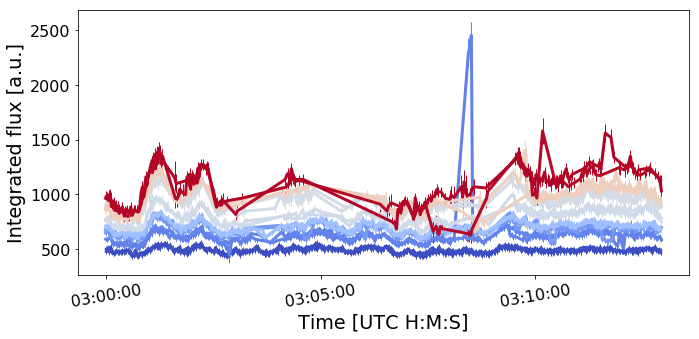

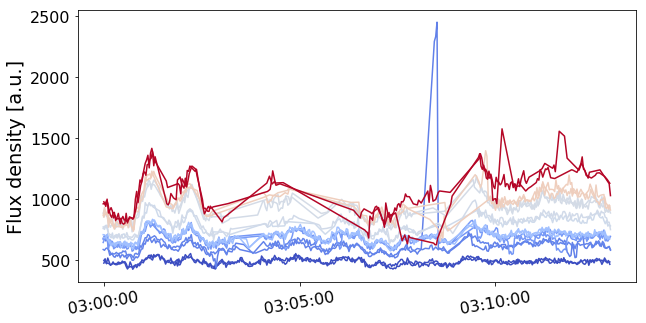

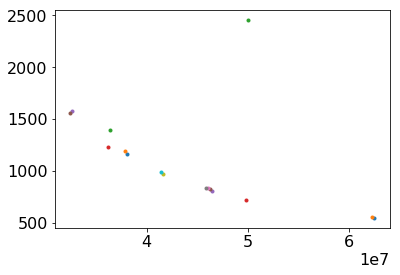

6.37104246461 64.1344197961


In [27]:
%matplotlib inline
n_c = 0

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(TR_data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)



n_c = 0 
plt.figure(1, figsize = (10,5))
# plt.figure(2, figsize=(12,8))

for freq in all_freq[::-1]:
    plt.figure(1, figsize = (10,5))
#     plt.figure(1, figsize = (12,8))
    ax = plt.subplot(111)

    burst = TR_data[(TR_data.freq_eff == freq)]# &
#                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
#                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()

    
    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

    if freq > 60000000:
#         ax.plot(xaxis, 27.13*burst.f_int, 
#                 c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))
        ax.errorbar(xaxis, burst.f_int, yerr=burst.f_int_err, linewidth=3,elinewidth=1,
                c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

    elif freq < 60000000:
#         ax.plot(xaxis, 24.9*burst.f_int, 
#                 c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

        ax.errorbar(xaxis, burst.f_int, yerr=burst.f_int_err, linewidth=3,elinewidth=1,
                c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

        
        
#     plt.figure(2, figsize=(12,8))
#     ax1 = plt.subplot(111)
#     ax1.plot(xaxis, burst.f_int/burst.det_sigma , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))
    plt.figure(2, figsize = (10,5))
    ax2 = plt.subplot(111)
    
#     plt.plot(burst.f_int.rolling(10, win_type="gaussian").mean(std=3), c=colors[n_c])
    plt.plot(burst.f_int, c=colors[n_c])
    
#     plt.title(dbname+": "+str(pd.to_datetime(burst.iloc[0].taustart_ts).date()))
    myFmt = mdates.DateFormatter('%H:%M:%S')
    plt.xticks(rotation=10)
    ax2.xaxis.set_major_formatter(myFmt)
    plt.ylabel("Flux density [a.u.]")

    
    plt.figure(3)
#     plt.plot(freq, np.sum(burst[np.argmax(burst.f_int.values)-20:np.argmax(burst.f_int.values)+20].f_int), ".")
    plt.plot(freq, np.max(burst.f_int), ".")

    n_c += 1
    
plt.figure(1, figsize = (10,5))
# plt.title(dbname+": "+str(pd.to_datetime(burst.iloc[0].taustart_ts).date()))
# plt.figure(1, figsize=(10,8))
myFmt = mdates.DateFormatter('%H:%M:%S')
plt.xticks(rotation=10)
ax.xaxis.set_major_formatter(myFmt)
# ax.set_ylim([-300,500])
plt.ylabel("Integrated flux [a.u.]")
# plt.legend(ncol=2)
# plt.title(_ID)
plt.xlabel("Time [UTC H:M:S]")
# burst_starts = (TR_data.loc[TR_data.f_int.idxmax()].taustart_ts 
#                 - pd.to_timedelta(10,unit='s'))

# burst_ends = (TR_data.loc[TR_data.f_int.idxmax()].taustart_ts 
#                 + pd.to_timedelta(20,unit='s'))

# plt.xlim(burst_starts,burst_ends)

plt.tight_layout()
plt.show()

print TR_data.ra.mean(), TR_data.decl.mean(), 

6.37104246461 64.1344197961


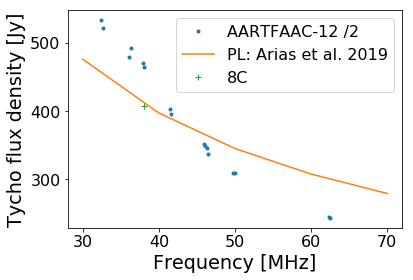

In [79]:
def powlaw(x,a,b):
    return a*x**b


plt.figure()
plt.plot(TR_data.groupby("freq_eff").mean().index/1e6, 
         TR_data.groupby("freq_eff").mean().f_int/2., ".",  label="AARTFAAC-12 /2")
# plt.xscale("log")
# plt.yscale("log")

plt.ylabel("Tycho flux density [Jy]")
plt.xlabel("Frequency [MHz]")

plt.plot([30,40,50,60,70], 
         52.3*(np.array([30,40,50,60,70])/1000.)**(-0.63), 
        label="PL: Arias et al. 2019")
plt.plot(38,408, "+", label="8C")
plt.legend()
plt.xticks([30,40,50,60,70])
print TR_data.ra.mean(), TR_data.decl.mean()

In [42]:
fit = np.polyfit(np.log10(TR_data.groupby("freq_eff").mean().index/1e6),
          np.log10(TR_data.groupby("freq_eff").mean().f_int),1 )
print fit

from scipy.optimize import curve_fit

fit,cov = curve_fit(powlaw, 
            TR_data.groupby("freq_eff").mean().index/1e6, 
            TR_data.groupby("freq_eff").mean().f_int )
print fit

[-1.25642514  4.93654979]
[ 8.44279285e+04 -1.25005072e+00]


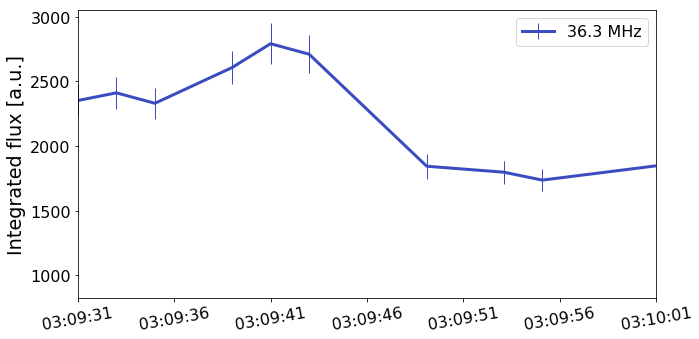

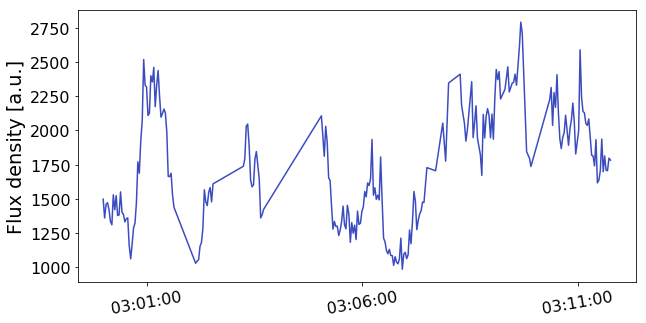

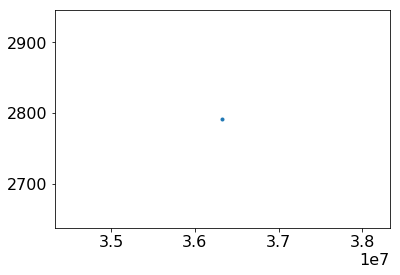

83.6585437759 22.0336745773


In [6]:
%matplotlib inline
n_c = 0

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False


plt.figure(1, figsize = (10,5))
# plt.figure(2, figsize=(12,8))
for freq in all_freq[::-1]:
    plt.figure(1, figsize = (10,5))
#     plt.figure(1, figsize = (12,8))
    ax = plt.subplot(111)

    burst = TR_data[(TR_data.freq_eff == freq) ]# &
#                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
#                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()

    
    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]


    ax.errorbar(xaxis, burst.f_int, yerr=burst.f_int_err, linewidth=3,elinewidth=1,
            c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))


        
        
#     plt.figure(2, figsize=(12,8))
#     ax1 = plt.subplot(111)
#     ax1.plot(xaxis, burst.f_int/burst.det_sigma , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))
    plt.figure(2, figsize = (10,5))
    ax2 = plt.subplot(111)
    
#     plt.plot(burst.f_int.rolling(10, win_type="gaussian").mean(std=3), c=colors[n_c])
    plt.plot(burst.f_int, c=colors[n_c])
    
#     plt.title(dbname+": "+str(pd.to_datetime(burst.iloc[0].taustart_ts).date()))
    myFmt = mdates.DateFormatter('%H:%M:%S')
    plt.xticks(rotation=10)
    ax2.xaxis.set_major_formatter(myFmt)
    plt.ylabel("Flux density [a.u.]")

    
    plt.figure(3)
#     plt.plot(freq, np.sum(burst[np.argmax(burst.f_int.values)-20:np.argmax(burst.f_int.values)+20].f_int), ".")
    plt.plot(freq, np.max(burst.f_int), ".")

    n_c += 1
    
plt.figure(1, figsize = (10,5))
# plt.title(dbname+": "+str(pd.to_datetime(burst.iloc[0].taustart_ts).date()))
# plt.figure(1, figsize=(10,8))
myFmt = mdates.DateFormatter('%H:%M:%S')
plt.xticks(rotation=10)
ax.xaxis.set_major_formatter(myFmt)
# ax.set_ylim([-300,500])
plt.ylabel("Integrated flux [a.u.]")
# plt.legend(ncol=2)
# plt.title(_ID)
# plt.xlabel("Time [UTC H:M:S]")
# burst_starts = (TR_data.loc[TR_data.f_int.idxmax()].taustart_ts 
#                 - pd.to_timedelta(10,unit='s'))

# burst_ends = (TR_data.loc[TR_data.f_int.idxmax()].taustart_ts 
#                 + pd.to_timedelta(20,unit='s'))

plt.xlim(burst_starts,burst_ends)
plt.legend()
plt.tight_layout()
plt.show()

print TR_data.ra.mean(), TR_data.decl.mean(), 